### Install necessary library and dataset
- if you don't have git you directly download it from https://github.com/srohit0/food_mnist.git with your browser

In [ ]:
!pip install torch torchvision pillow requests opencv-python matplotlib
!git clone https://github.com/srohit0/food_mnist.git

### Import all necessary packages

In [2]:
import food_mnist
import matplotlib.pyplot as plt
import cv2
import torch, numpy
import torch
from torchvision import models, transforms
from PIL import Image
import requests
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
import time
from torch.utils.data import Subset

### Functions to manipulate images with the right format

In [4]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"

# Define preprocessing operations for images since 
#the pretrained model expects 224x224 images normalized with ImageNet stats
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),        # Resize shortest side to 224x224
    transforms.ToTensor(),                # Convert to PyTorch tensor
    transforms.Normalize(                 # Normalize using ImageNet means/stds
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])
def preprocess_images(x):
    return torch.stack([preprocess(Image.fromarray(img.astype('uint8'))) for img in x])

#Display an image with its title (rebuild the image from tensors)
def imshow(img_tensor, title=None):
    img = img_tensor.cpu().numpy().transpose(1,2,0)  # C,H,W -> H,W,C
    img = img * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406])  # unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis("off")

### Functions to evaluate a model
- on a single image (predefined)
- on a single batch (of size 8 showing in a grid the images)
- on the full test set

In [5]:
#Need the categories/labels used
def test_single_image(model,categories):
    image_path = "food_mnist/images/apple_pie/118237.jpg"  # replace with your image path
    image = Image.open(image_path).convert("RGB")
    # Apply preprocessing
    input_tensor = preprocess(image).unsqueeze(0)  # Add a batch dimension for a single image

    #Run inference
    with torch.no_grad():
        outputs = model(input_tensor.to(device))
        #special case as we have a single image here, we do the softmax on the full batch so dim=0
        probabilities = torch.nn.functional.softmax(outputs[0], dim=0)

    

    # Get top-5 predictions
    top5_prob, top5_catid = torch.topk(probabilities, 5)

    print("\nTop 5 Predictions:")
    for i in range(top5_prob.size(0)):
        print(f"{categories[top5_catid[i]]}: {top5_prob[i].item() * 100:.2f}%")

    # show image
    image.show()

#Need the categories/labels used
def test_batch(model,images,categories):

    with torch.no_grad():
        outputs = model(images.to(device))
        probs = torch.nn.functional.softmax(outputs, dim=1)
        top_prob, top_catid = torch.topk(probs, 1)
        # !!! Now we have run the inference for a batch, so softmax we done for each image in the batch... so the function above return a set of probablities and categories !

        plt.figure(figsize=(12,6))
        for i in range(my_batch_size):
            plt.subplot(2,4,i+1)
            title = f"Top-1: {categories[top_catid[i][0]]}\nConf: {top_prob[i][0]*100:.1f}%"
            imshow(images[i], title)
        plt.tight_layout()
        plt.show()

#Categories are again the mapping of neural net output with ccategories
#true_label are label as stated in the dataset (ground_truth)
def test_all(model,images,categories,true_labels):   
    total_correct = 0
    total_images = 0

    #Food dataset provides grountrth as numeric label, we need to get their text values (check github repo of the dataset)
    food_labels = ["apple pie","baby back ribs","baklava","beef carpaccio","beef tartare","beet salad","beignets","bibimbap","bread pudding","breakfast burrito"]

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            top_prob, top_catid = torch.max(probs, 1)
    
            total_images +=len(images)
            
            for i in range(len(images)):
                #Get predicted label and comapre to the real one
                #predict_label = imagenet_labels[top_catid[i][0]]
                true_label = food_labels[labels[i].item()]         # ground-truth
                pred_class = categories[top_catid[i].item()]    # predicted class
           
                if true_label == pred_class:
                    total_correct+=1
        
    accuracy = total_correct / total_images * 100
    print(f"Total correct predictions: {total_correct}/{total_images}")
    print(f"Overall test accuracy: {accuracy:.2f}%")

### No fine-tuning
1. Load the pre-trained model
2. Load the dataset and format it as tensors in data loader
3. Test the first batch of data and display it with pictures
4. Test on the test set

In [6]:
# Load ResNet-18 with pretrained weights on ImageNet
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.to(device)
model.eval()  # Set model to evaluation mode (important for inference)

param_size = sum(p.numel() * p.element_size() for p in model.parameters())
buffer_size = sum(b.numel() * b.element_size() for b in model.buffers())
total_size = (param_size + buffer_size) / 1024**2  # Convert to MB

#Show mode size
print(f"Model size: {total_size:.2f} MB")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/frear/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:01<00:00, 39.2MB/s]


Model size: 44.63 MB


In [7]:
#load data
(x_train, y_train), (x_test, y_test) = food_mnist.load_data(224,224)

# Convert all images from BGR to RGB
x_train = x_train[:,:,:,:][:,:,:,::-1].copy()
x_test  = x_test[:,:,:,:][:,:,:,::-1].copy()

#create tensors
#Uses only 128 images for test (you can change this value below (up to 1250)
x_train_tensor = preprocess_images(x_train)
y_train_tensor = torch.tensor(y_train)
x_test_tensor  = preprocess_images(x_test[:128])
y_test_tensor  = torch.tensor(y_test[:128])



#create data loaders
my_batch_size=8

#Create the tensor dataset and make it ready for use with a batch size of 8 (can be changed)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, my_batch_size, shuffle=False)


print("############## No fine-tuning ##############")

############## No fine-tuning ##############


- Test on a single image

In [8]:
# Decode prediction
# Get ImageNet class labels
# (torchvision provides them through the weights metadata)
categories = models.ResNet18_Weights.IMAGENET1K_V1.meta["categories"]

#Test a single image
test_single_image(model,categories)


Top 5 Predictions:
plate: 34.41%
meat loaf: 15.35%
burrito: 14.81%
potpie: 11.26%
French loaf: 6.18%


- Test on a single batch

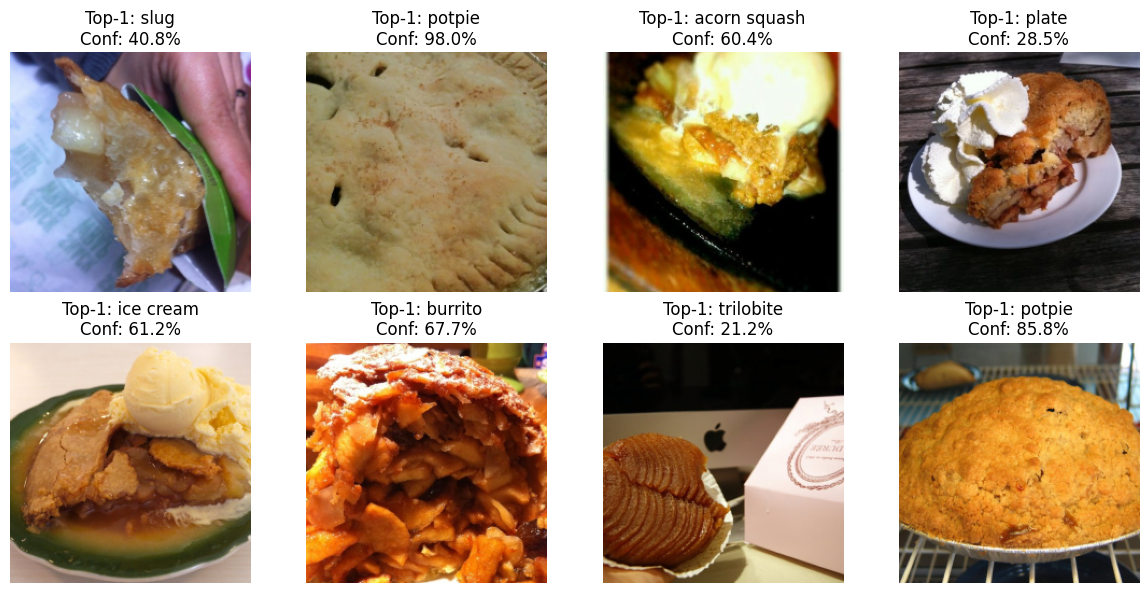

In [9]:
#Test the first batch of test data and get the top probabilities and top categories/labels
images, labels = next(iter(test_loader))

# Get ImageNet class labels
# (torchvision provides them through the weights metadata)
categories = models.ResNet18_Weights.IMAGENET1K_V1.meta["categories"]
test_batch(model,images,categories)

- Test on the test set


In [10]:
images, labels = next(iter(test_loader))

# Get ImageNet class labels
# (torchvision provides them through the weights metadata)
categories = models.ResNet18_Weights.IMAGENET1K_V1.meta["categories"]

#WHat are the true labels of the dataset, check for the dataset online or in food_mnist directory 
true_labels = ["apple pie","baby back ribs","baklava","beef carpaccio","beef tartare","beet salad","beignets","bibimbap","bread pudding","breakfast burrito"]

test_all(model,images,categories,true_labels)

Total correct predictions: 0/128
Overall test accuracy: 0.00%


### Load a fine-tuned model

In [11]:
# !!! TODO
#use torch.load function similar to the pre-trained model
#using the given fine-tuned model 



sft_model.to(device)


NameError: name 'sft_model' is not defined

- Test the model using the different test functions
- Note: the model has been fine-tune according to the category of the MNIST food dataset

In [ ]:
model.eval() 

#!!!! TODO here

### Fine-tune your model
1. replace the feed-forward network head (fully connected layer)  by a new linear model according to the number of class
2. makes all parameters trainable
3. configure optimizer. You can adjust the different parameters and see the impact on performance
4. Select a subset of training data (faster). You can adjust this parameter and see the impact
5. Train your model
6. Save your model

In [ ]:
print("############## Fine-tuning ##############")

num_classes = 10  # Food-MNIST

# Replace the final layer named fc in ResNet-18 (fc for fully connected) and in_features is the size of the input vector)
# !! TODO: the code below needs to be completed
print(model.fc) #original model
model.fc = nn.Linear(model.fc.....)
print(model.fc) #fine-tuned model (not yet fine-tuned)

# Keep all layers trainable (full fine-tuning)
for param in model.parameters():
    param.requires_grad = True  # make sure all layers are updated


#Configure the optimization
# !! TODO You can change the learning rate or the number of epochs
criterion = nn.CrossEntropyLoss() #usual metric for classification
optimizer = optim.Adam(model.parameters(), lr=1e-2) 
num_epochs = 5


start_time = time.time()  # record overall start time

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
# Choose a subset size, e.g. 10% of the training set
subset_size = int(1.0 * len(train_dataset))  # 10%

# Randomly select subset indices
subset_indices = np.random.choice(len(train_dataset), subset_size, replace=False)

# Create subset dataset
train_subset = Subset(train_dataset, subset_indices)
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=32, shuffle=True)


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {running_loss/total:.4f} - Acc: {correct/total*100:.3f}%")

total_time = time.time() - start_time
print(f"Total training time: {total_time/60:.2f} minutes ({total_time:.1f} seconds)")

In [ ]:
model.eval() 

## !! TODO evaluate the model on a single image, single batch and full test set

In [ ]:
torch.save(model, "my_first_sft_model.pth")